### Imports

In [1]:
# Libraries
import os
from importlib import reload

import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Scripts
from helpers import data, runners, utils, generators

In [2]:
!pip show tensorflow # Should be v2.10

Name: tensorflow
Version: 2.10.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: c:\users\sonar\anaconda3v2\envs\acml_2024\lib\site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, keras-preprocessing, libclang, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: 


In [3]:
!pip show keras # Should be v2.10

Name: keras
Version: 2.10.0
Summary: Deep learning for humans.
Home-page: https://keras.io/
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache 2.0
Location: c:\users\sonar\anaconda3v2\envs\acml_2024\lib\site-packages
Requires: 
Required-by: keras-tuner, tensorflow


In [4]:
reload(runners)
reload(data)
reload(utils)

<module 'helpers.utils' from 'c:\\Users\\sonar\\Desktop\\thesis-ml\\ml\\main\\helpers\\utils.py'>

In [5]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

# Check whether tf is using the GPU
utils.check_gpu_use() 

GPU DETECTED ✓
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## `main`

In [ ]:
DATA_BATCH_SIZE = 16
GPU_BATCH_SIZE = 4
NUM_EPOCHS = 1

### Load data

In [7]:
pairs_df = pd.read_csv("../data/DATASET_CSVS/deepship_pairs_diff_recording.csv")

print(pairs_df.shape)

(12880, 5)


In [8]:
# ADD RELATIVE PATH

PATH_TO_ROOT = "..\\data\\"
pairs_df["file_path_1"] = pairs_df["file_path_1"].apply(
    lambda x: PATH_TO_ROOT + x
)
pairs_df["file_path_2"] = pairs_df["file_path_2"].apply(
    lambda x: PATH_TO_ROOT + x
)

pairs_df.head(2)

,ship_name,file_path_1,date_seg_1,file_path_2,date_seg_2
0,ALFRED_N,..\data\deepship_baseline_mat\Tanker\ALFRED_N-...,20170326_1,..\data\deepship_baseline_mat\Tanker\ALFRED_N-...,20170403_51
1,ALFRED_N,..\data\deepship_baseline_mat\Tanker\ALFRED_N-...,20170326_2,..\data\deepship_baseline_mat\Tanker\ALFRED_N-...,20170403_48


In [9]:
# Get testing split
train, test = train_test_split(
    pairs_df,
    test_size=0.2,
    random_state=100,
    shuffle=True
)

In [10]:
# Initialise generators
train_gen = generators.N2NGenerator(
    train,
    'mat',
    'Pexp',
    batch_size=DATA_BATCH_SIZE,
    shuffle=True,
    conv_channel=True
)

test_gen = generators.N2NGenerator(
    test,
    'mat',
    'Pexp',
    batch_size=DATA_BATCH_SIZE,
    shuffle=True,
    conv_channel=True
)

### Initialise model

In [11]:
def psnr(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

# Learning rate decay
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000, 
    decay_rate=0.9 
)

In [12]:
from models import unet, unetpro
reload(unetpro)

model = unetpro.get_unetpro_model(
    input_size=(192, 192, 1), 
    classes=1, # Use 1 for denoising
    dropout=0.2
) 

# model = unet.get_unet_model(
#     input_size=(192, 192, 1),
#     classes=1,
#     dropout=0.5
# )

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=keras.losses.MeanSquaredError(),
    metrics=[psnr]
)

model.summary()

Model: "unet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 192, 1  0           []                               
                                )]                                                                
                                                                                                  
 gaussian_noise (GaussianNoise)  (None, 192, 192, 1)  0          ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 192, 192, 8)  16          ['gaussian_noise[0][0]']         
                                                                                                  
 conv2d_1 (Conv2D)              (None, 192, 192, 8)  80          ['gaussian_noise[0][0]']      

### Train model

In [ ]:
keras.backend.clear_session()

# [DBS=16, GBS=4] Entire dataset + 1 epoch = 24 min
# [DBS=16, GBS=4] Entire dataset + 10 epochs = 235 min

history = model.fit(
    train_gen,
    batch_size=GPU_BATCH_SIZE,
    epochs=NUM_EPOCHS,
    verbose=2
)

644/644 - 1054s - loss: 0.0243 - psnr: 16.4573 - 1054s/epoch - 2s/step


In [14]:
evals = model.evaluate(
    test_gen,
    batch_size=GPU_BATCH_SIZE,
    verbose=2
)

161/161 - 70s - loss: 0.0239 - psnr: 16.5711 - 70s/epoch - 433ms/step


In [15]:
# model.save('models/saved/unet_denoiser_11112024/unet_denoiser.keras')
model.save('models/saved/unetpro_denoiser_13112024/unetpro_denoiser_10_epochs.keras')

### Evaluation, metrics, and visualising denoised output

In [16]:
# Get a few samples from the test generator for visualisation and metrics calculation
num_samples = 5 

sample_X, sample_y = next(iter(test_gen))
sample_inputs = sample_X[:num_samples]  # Extract the first `num_samples` examples from the batch
sample_outputs = sample_y[:num_samples]  # Extract the first `num_samples` examples from the batch

# Predict the denoised outputs
denoised_outputs = model.predict(sample_inputs)

1/1 [==============================] - 7s 7s/step


In [17]:
# Get evaluation metrics
mse_score = tf.keras.losses.MeanSquaredError()(sample_inputs, denoised_outputs).numpy()
psnr_score = psnr(sample_inputs, denoised_outputs).numpy()

print(f"MSE on sample batch: {mse_score}")
print(f"PSNR on sample batch: {psnr_score}")

MSE on sample batch: 0.015461359173059464
PSNR on sample batch: [19.580683 18.056538 18.448523 18.383518 16.606274]


In [18]:
# Check if all outputs are normalised
for i, output in enumerate(denoised_outputs):
    print(f"Sample {i+1} - Min: {np.min(output)}; Max: {np.max(output)}")

Sample 1 - Min: 0.38841304183006287; Max: 0.7628440856933594
Sample 2 - Min: 0.36603790521621704; Max: 0.7733405828475952
Sample 3 - Min: 0.4170421361923218; Max: 0.7678588032722473
Sample 4 - Min: 0.415179967880249; Max: 0.7601637244224548
Sample 5 - Min: 0.4091333746910095; Max: 0.785885214805603


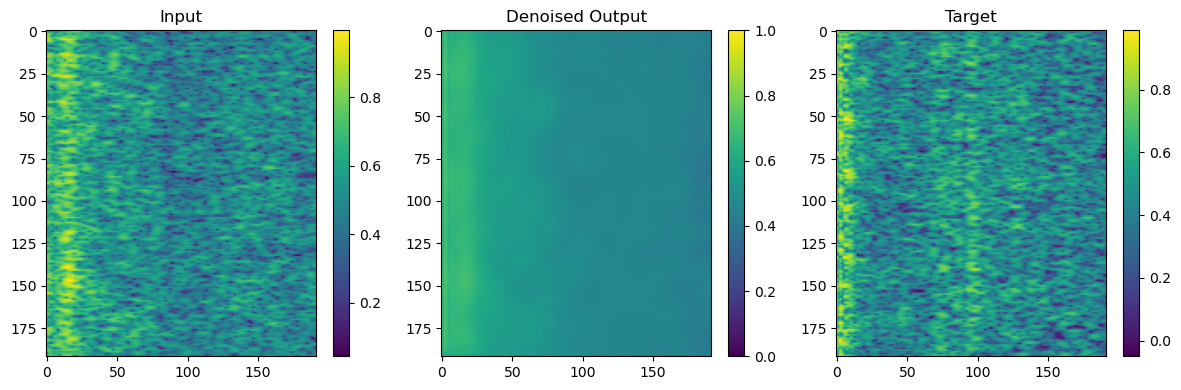

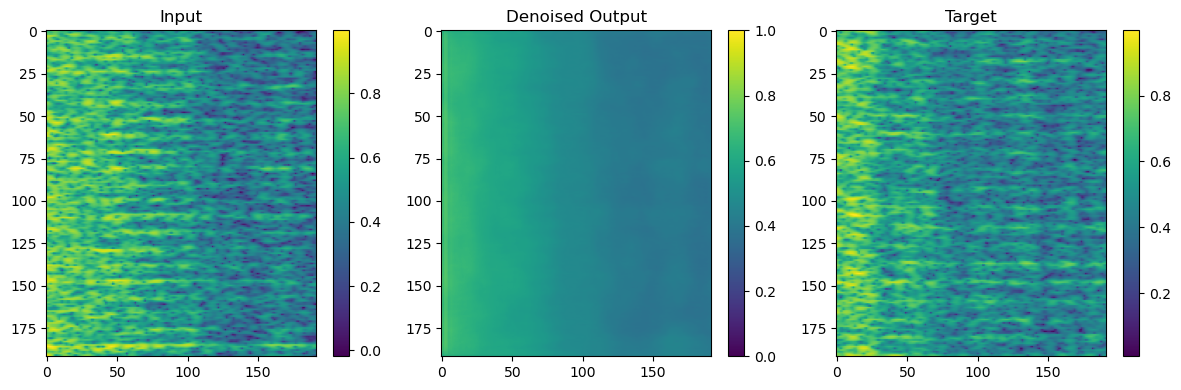

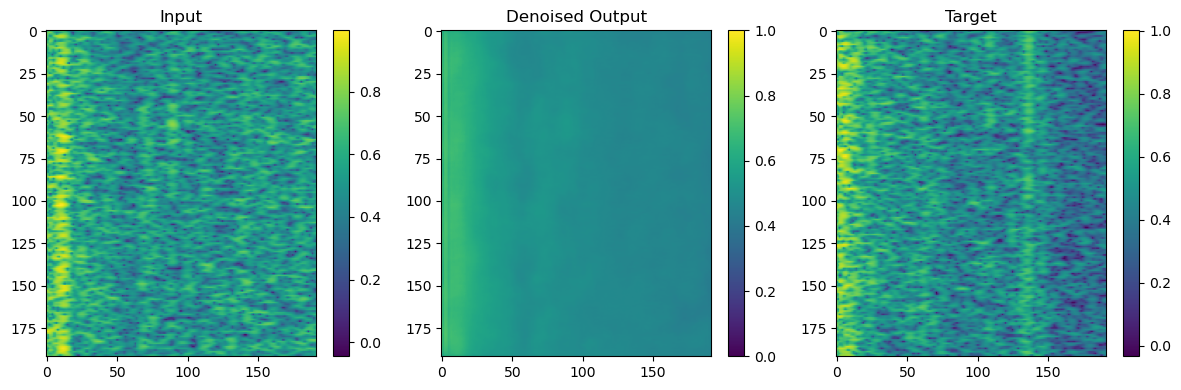

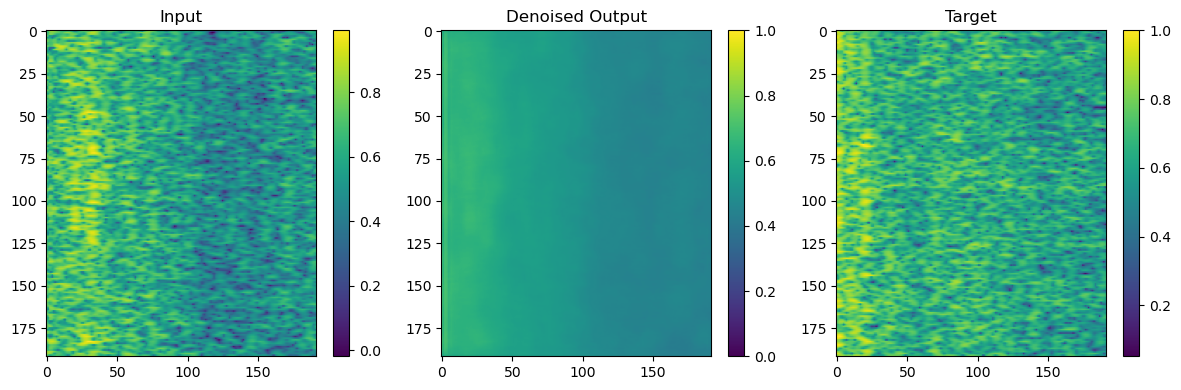

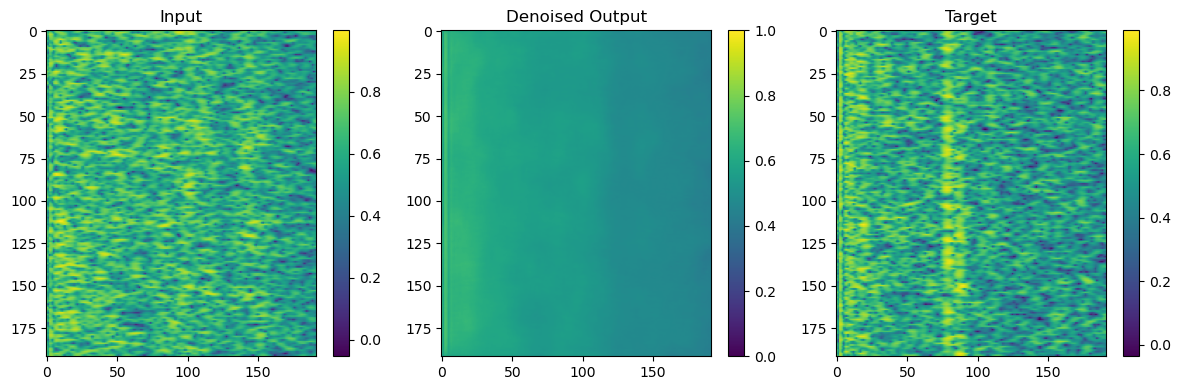

In [19]:
# Plot the input, output, and target spectrograms for each sample
for i in range(num_samples):
    plt.figure(figsize=(12, 4))
    
    # INPUT
    plt.subplot(1, 3, 1)
    plt.imshow(sample_inputs[i].squeeze(), cmap="viridis", aspect="auto")
    plt.title("Input")
    plt.colorbar()

    # DENOISED OUTPUT
    plt.subplot(1, 3, 2)
    plt.imshow(denoised_outputs[i].squeeze(), cmap="viridis", aspect="auto")
    plt.title("Denoised Output")
    plt.colorbar()
    plt.clim(0, 1)

    # TARGET
    plt.subplot(1, 3, 3)
    plt.imshow(sample_outputs[i].squeeze(), cmap="viridis", aspect="auto")
    plt.title("Target")
    plt.colorbar()
    
    plt.tight_layout()
    plt.show()